## first case


Using device: cuda
Calculating traditional ODE solution with scipy.integrate.odeint...
Traditional solution calculated.

Starting PINN training...
Epoch 500/4000:
  ODE Loss G: 4.910002e+04
  ODE Loss I: 6.127560e+01
  Total ODE Loss (weighted): 4.473915e+05
  IC Loss G: 4.840750e-01
  IC Loss I: 3.434983e-02
  Total IC Loss (weighted): 1.623974e+02
  Total Loss: 4.475539e+05

Epoch 1000/4000:
  ODE Loss G: 1.620388e+03
  ODE Loss I: 4.400893e+01
  Total ODE Loss (weighted): 2.876784e+05
  IC Loss G: 2.204049e+00
  IC Loss I: 5.875537e-03
  Total IC Loss (weighted): 6.641523e+02
  Total Loss: 2.883426e+05

Epoch 1500/4000:
  ODE Loss G: 1.284226e+03
  ODE Loss I: 3.274626e+01
  Total ODE Loss (weighted): 2.141349e+05
  IC Loss G: 1.739681e+00
  IC Loss I: 5.505097e-03
  Total IC Loss (weighted): 5.246569e+02
  Total Loss: 2.146595e+05

Epoch 2000/4000:
  ODE Loss G: 9.671439e+02
  ODE Loss I: 2.457803e+01
  Total ODE Loss (weighted): 1.607243e+05
  IC Loss G: 1.309568e+00
  IC Loss I: 

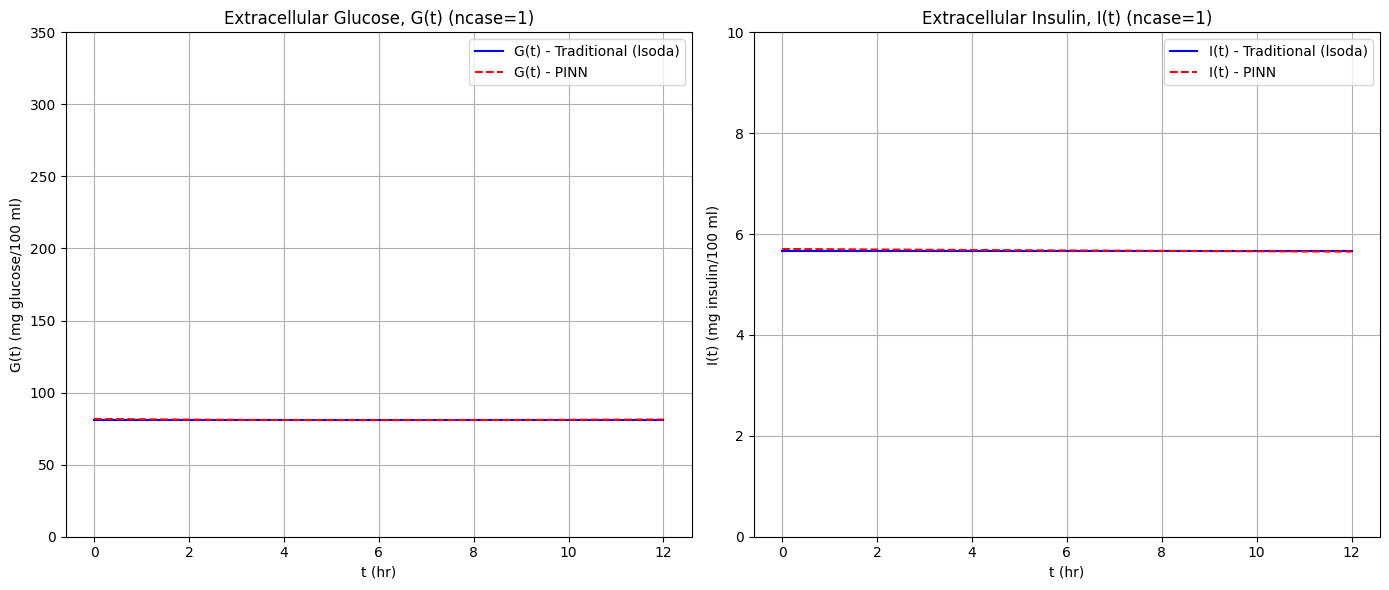


--- Final Values Comparison (at t=12.0) ---
Traditional G(12): 81.1392
Traditional I(12): 5.6709
PINN G(12): 81.3384
PINN I(12): 5.6532

(Note: PINN results will approach traditional results with more epochs and hyperparameter tuning.)


In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random

# --- 1. Global Setup for Reproducibility and Device ---
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Define Parameters for ncase = 3 ---
# Extracted from the document (pages 88, 89, 94)
params_ncase3 = {
    'Ex': 15000,
    'Cg': 150,  # Ex / 100
    'Ci': 150,  # Ex / 100
    'Q': 8400,
    'Dd': 24.7,
    'Gg': 13.9,
    'Gk': 250,
    'Mu': 72,
    'Go': 51,
    'Aa': 76,
    'Bb': 14.3, # Reduced pancreatic sensitivity for ncase=3
    'Gt': 0 # Glucose infusion rate (used for In)
}

# Initial conditions
y0_initial = [81.14, 5.671] # [G(0), I(0)]

# Time points for simulation
t_span_sim = np.linspace(0, 12, 500) # 500 points for smooth plot

# --- 3. Traditional ODE Solution (using scipy.integrate.odeint) ---

# Glucose infusion function In(t) for traditional solver
def In_func_traditional(t, Gt_val):
    if 0 <= t < 0.5:
        return Gt_val
    else:
        return 0

# ODE system definition for traditional solver
def odes_traditional(y, t, params):
    G, I = y[0], y[1]

    # Unpack parameters
    Cg = params['Cg']
    Ci = params['Ci']
    Q = params['Q']
    Dd = params['Dd']
    Gg = params['Gg']
    Gk = params['Gk']
    Mu = params['Mu']
    Go = params['Go']
    Aa = params['Aa']
    Bb = params['Bb']
    Gt = params['Gt']

    In = In_func_traditional(t, Gt)

    # Glucose ODE (Eq. 2.1b & 2.1c)
    dGdt = (Q + In - Gg * I * G - Dd * G) / Cg
    if G >= Gk:
        dGdt -= (Mu * (G - Gk)) / Cg

    # Insulin ODE (Eq. 2.2b & 2.2c)
    dIdt = (-Aa * I) / Ci
    if G >= Go:
        dIdt += (Bb * (G - Go)) / Ci

    return [dGdt, dIdt]

print("Calculating traditional ODE solution with scipy.integrate.odeint...")
solution_traditional = odeint(odes_traditional, y0_initial, t_span_sim, args=(params_ncase3,))
G_traditional = solution_traditional[:, 0]
I_traditional = solution_traditional[:, 1]
print("Traditional solution calculated.")

# --- 4. Physics-Informed Neural Network (PINN) Implementation ---

# Neural Network Architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Define ranges for input (time) and outputs (G, I) for scaling
        self.t_min, self.t_max = 0.0, 12.0
        # Estimate reasonable output ranges based on traditional solution's behavior
        # Adjusted G_max slightly based on graph (peak around 300)
        self.G_min, self.G_max = 70.0, 310.0
        # Adjusted I_max slightly based on graph (peak around 6-7, but PINN overshot to ~9.5 previously)
        # Setting it slightly higher than typical peak to allow PINN to learn better without saturation
        self.I_min, self.I_max = 2.0, 10.0

        self.net = nn.Sequential(
            nn.Linear(1, 64), # Input: scaled time [-1, 1]
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output: scaled G and I, both [-1, 1]
        )
        # Initialize weights with Xavier uniform for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # Store parameters as torch tensors on the device for PINN calculations
        self.Cg = torch.tensor(params_ncase3['Cg'], dtype=torch.float32).to(device)
        self.Ci = torch.tensor(params_ncase3['Ci'], dtype=torch.float32).to(device)
        self.Q = torch.tensor(params_ncase3['Q'], dtype=torch.float32).to(device)
        self.Dd = torch.tensor(params_ncase3['Dd'], dtype=torch.float32).to(device)
        self.Gg = torch.tensor(params_ncase3['Gg'], dtype=torch.float32).to(device)
        self.Gk = torch.tensor(params_ncase3['Gk'], dtype=torch.float32).to(device)
        self.Mu = torch.tensor(params_ncase3['Mu'], dtype=torch.float32).to(device)
        self.Go = torch.tensor(params_ncase3['Go'], dtype=torch.float32).to(device)
        self.Aa = torch.tensor(params_ncase3['Aa'], dtype=torch.float32).to(device)
        self.Bb = torch.tensor(params_ncase3['Bb'], dtype=torch.float32).to(device)
        self.Gt = torch.tensor(params_ncase3['Gt'], dtype=torch.float32).to(device)

    def forward(self, t_unscaled):
        # Scale time input to [-1, 1] for the neural network
        t_scaled = 2 * (t_unscaled - self.t_min) / (self.t_max - self.t_min) - 1

        # Get scaled predictions from the neural network
        output_scaled = self.net(t_scaled)

        # Unscale G and I predictions back to original physical units
        G_pred_unscaled = self.G_min + (self.G_max - self.G_min) * (output_scaled[:, 0] + 1) / 2
        I_pred_unscaled = self.I_min + (self.I_max - self.I_min) * (output_scaled[:, 1] + 1) / 2

        # Concatenate and return as a single tensor
        return torch.cat((G_pred_unscaled.unsqueeze(1), I_pred_unscaled.unsqueeze(1)), dim=1)

    # Glucose infusion function for PINN (differentiable using torch.where)
    def In_func_pinn(self, t):
        return torch.where(t < 0.5, self.Gt, torch.tensor(0.0, device=device))

    # Compute ODE residuals (f_G and f_I)
    def compute_ode_residuals(self, t):
        # Ensure time input requires gradients for derivative computation
        t.requires_grad_(True)

        # Predict G and I (unscaled) from the neural network
        y_pred = self.forward(t)
        G_pred = y_pred[:, 0].unsqueeze(1) # Ensure shape (N, 1) for gradient calculation
        I_pred = y_pred[:, 1].unsqueeze(1) # Ensure shape (N, 1)

        # Compute derivatives dG/dt and dI/dt using autograd
        # Note: grad will correctly apply chain rule due to scaling in forward
        dG_dt = grad(G_pred, t, torch.ones_like(G_pred), create_graph=True)[0]
        dI_dt = grad(I_pred, t, torch.ones_like(I_pred), create_graph=True)[0]

        # Calculate In(t) for current time points
        In_val = self.In_func_pinn(t)

        # Conditional terms for Glucose ODE (renal removal)
        # Mu*(G-Gk) term is SUBTRACTED from the RHS of the glucose equation.
        # So, in the residual (LHS - RHS), it becomes +Mu*(G-Gk).
        Mu_term = torch.where(G_pred >= self.Gk, self.Mu * (G_pred - self.Gk), torch.tensor(0.0, device=device))

        # Glucose ODE residual (LHS - RHS)
        # Cg * dG/dt - (Q + In - Gg * I * G - Dd * G - Mu_term) = 0
        f_G = self.Cg * dG_dt - (self.Q + In_val - self.Gg * I_pred * G_pred - self.Dd * G_pred - Mu_term)

        # Conditional terms for Insulin ODE (pancreas release)
        # Bb*(G-Go) term is ADDED to the RHS of the insulin equation.
        # So, in the residual (LHS - RHS), it becomes -Bb*(G-Go).
        Bb_term = torch.where(G_pred >= self.Go, self.Bb * (G_pred - self.Go), torch.tensor(0.0, device=device))

        # Insulin ODE residual (LHS - RHS)
        # Ci * dI/dt - (-Aa * I + Bb_term) = 0
        f_I = self.Ci * dI_dt - (-self.Aa * I_pred + Bb_term)

        return f_G.pow(2).mean(), f_I.pow(2).mean() # Return mean squared residuals

    # Compute initial condition loss
    def compute_initial_condition_loss(self, G0_true, I0_true):
        t0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
        y0_pred = self.forward(t0) # Predict G(0) and I(0) (unscaled)
        G0_pred = y0_pred[0, 0]
        I0_pred = y0_pred[0, 1]

        loss_G0 = (G0_pred - G0_true).pow(2)
        loss_I0 = (I0_pred - I0_true).pow(2)
        return loss_G0, loss_I0

# Instantiate the PINN model
pinn_model = PINN().to(device)
optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)

# Initial conditions as torch tensors (unscaled, as they are target values)
G0_true_tensor = torch.tensor(y0_initial[0], dtype=torch.float32, device=device)
I0_true_tensor = torch.tensor(y0_initial[1], dtype=torch.float32, device=device)

# Collocation points for ODE loss (randomly sampled across the time domain)
num_collocation_points = 1000
t_collocation = torch.linspace(0, 12, num_collocation_points, dtype=torch.float32, device=device).unsqueeze(1)
# Add some random jitter to collocation points for better exploration of solution space
t_collocation = t_collocation + (torch.rand_like(t_collocation) - 0.5) * (t_span_sim[1] - t_span_sim[0]) / 2
t_collocation = torch.clamp(t_collocation, 0, 12) # Ensure points stay within [0, 12]

# --- 5. PINN Training Loop ---
epochs = 4000 # Increased epochs based on typical PINN convergence and user screenshot
print("\nStarting PINN training...")
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()

    # Calculate ODE residuals loss
    loss_f_G, loss_f_I = pinn_model.compute_ode_residuals(t_collocation)

    # --- Critical Adjustment: Loss Weighting ---
    # The ODE Loss G is much larger than ODE Loss I in your output.
    # This means the network prioritizes fitting G, potentially neglecting I.
    # We need to weigh ODE Loss I much higher to balance the optimization.
    weight_G_ode = 1.0
    weight_I_ode = 6500.0 # Significantly increase weight for I_ode loss (was 1.0)

    loss_ode = weight_G_ode * loss_f_G + weight_I_ode * loss_f_I

    # Calculate initial condition loss
    loss_G0, loss_I0 = pinn_model.compute_initial_condition_loss(G0_true_tensor, I0_true_tensor)
    # IC loss is often weighted higher to ensure the solution starts correctly.
    # A weighting of 50-200 is common. Let's try 200 for ICs in general, to ensure a good start.
    weight_G_ic = 300.0 # Increased from 50
    weight_I_ic = 500.0
    loss_ic = weight_G_ic * loss_G0 + weight_I_ic * loss_I0

    # Total loss
    total_loss = loss_ode + loss_ic

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Print losses every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs}:")
        print(f"  ODE Loss G: {loss_f_G.item():.6e}")
        print(f"  ODE Loss I: {loss_f_I.item():.6e}")
        print(f"  Total ODE Loss (weighted): {loss_ode.item():.6e}")
        print(f"  IC Loss G: {loss_G0.item():.6e}")
        print(f"  IC Loss I: {loss_I0.item():.6e}")
        print(f"  Total IC Loss (weighted): {loss_ic.item():.6e}")
        print(f"  Total Loss: {total_loss.item():.6e}\n")

print("PINN training finished.")

# --- 6. Get PINN Predictions for Plotting ---
t_test_pinn = torch.tensor(t_span_sim, dtype=torch.float32, device=device).unsqueeze(1)
with torch.no_grad(): # Disable gradient calculations for inference
    y_pinn_pred = pinn_model(t_test_pinn) # Pass unscaled time
G_pinn = y_pinn_pred[:, 0].cpu().numpy()
I_pinn = y_pinn_pred[:, 1].cpu().numpy()

# --- 7. Plotting Results ---
plt.figure(figsize=(14, 6))

# Plot G(t)
plt.subplot(1, 2, 1)
plt.plot(t_span_sim, G_traditional, label='G(t) - Traditional (lsoda)', color='blue', linestyle='-')
plt.plot(t_span_sim, G_pinn, label='G(t) - PINN', color='red', linestyle='--')
plt.title('Extracellular Glucose, G(t) (ncase=1)')
plt.xlabel('t (hr)')
plt.ylabel('G(t) (mg glucose/100 ml)')
plt.grid(True)
plt.legend()
plt.ylim(0, 350) # Set Y-axis limit based on expected range for ncase=3

# Plot I(t)
plt.subplot(1, 2, 2)
plt.plot(t_span_sim, I_traditional, label='I(t) - Traditional (lsoda)', color='blue', linestyle='-')
plt.plot(t_span_sim, I_pinn, label='I(t) - PINN', color='red', linestyle='--')
plt.title('Extracellular Insulin, I(t) (ncase=1)')
plt.xlabel('t (hr)')
plt.ylabel('I(t) (mg insulin/100 ml)')
plt.grid(True)
plt.legend()
plt.ylim(0, 10) # Set Y-axis limit based on expected range for ncase=3

plt.tight_layout()
plt.show()

# --- 8. Verification of Final Values ---
# Compare with document values for ncase=3 at t=12.0 (Page 105)
# G(12) ~ 129.22, I(12) ~ 2.915
print("\n--- Final Values Comparison (at t=12.0) ---")
print(f"Traditional G(12): {G_traditional[-1]:.4f}")
print(f"Traditional I(12): {I_traditional[-1]:.4f}")
print(f"PINN G(12): {G_pinn[-1]:.4f}")
print(f"PINN I(12): {I_pinn[-1]:.4f}")
print("\n(Note: PINN results will approach traditional results with more epochs and hyperparameter tuning.)")

## second case

Using device: cpu
Calculating traditional ODE solution for Case 2...
Traditional solution calculated.

Starting Advanced PINN training for Case 2...
Epoch 1000/10000 | Loss: 2.895e+06 | ODE: 6.008e+05 | IC: 8.068e+01 | ContVal: 1.891e+04 | LR: 1.00e-03
Epoch 2000/10000 | Loss: 2.409e+06 | ODE: 3.500e+05 | IC: 1.217e+02 | ContVal: 1.450e+04 | LR: 1.00e-03
Epoch 3000/10000 | Loss: 2.122e+06 | ODE: 3.710e+05 | IC: 1.047e+02 | ContVal: 1.228e+04 | LR: 1.00e-03
Epoch 4000/10000 | Loss: 3.193e+05 | ODE: 1.427e+05 | IC: 2.571e+01 | ContVal: 4.801e+02 | LR: 1.00e-03
Epoch 5000/10000 | Loss: 1.344e+05 | ODE: 1.040e+05 | IC: 4.588e+00 | ContVal: 7.382e+01 | LR: 1.00e-03
Epoch 6000/10000 | Loss: 6.827e+04 | ODE: 6.632e+04 | IC: 2.920e-01 | ContVal: 4.882e+00 | LR: 1.00e-03
Epoch 7000/10000 | Loss: 3.528e+04 | ODE: 3.493e+04 | IC: 4.541e-03 | ContVal: 3.264e+00 | LR: 1.00e-03
Epoch 8000/10000 | Loss: 2.908e+04 | ODE: 2.892e+04 | IC: 1.099e-02 | ContVal: 1.111e+00 | LR: 1.00e-03
Epoch 9000/10000 | 

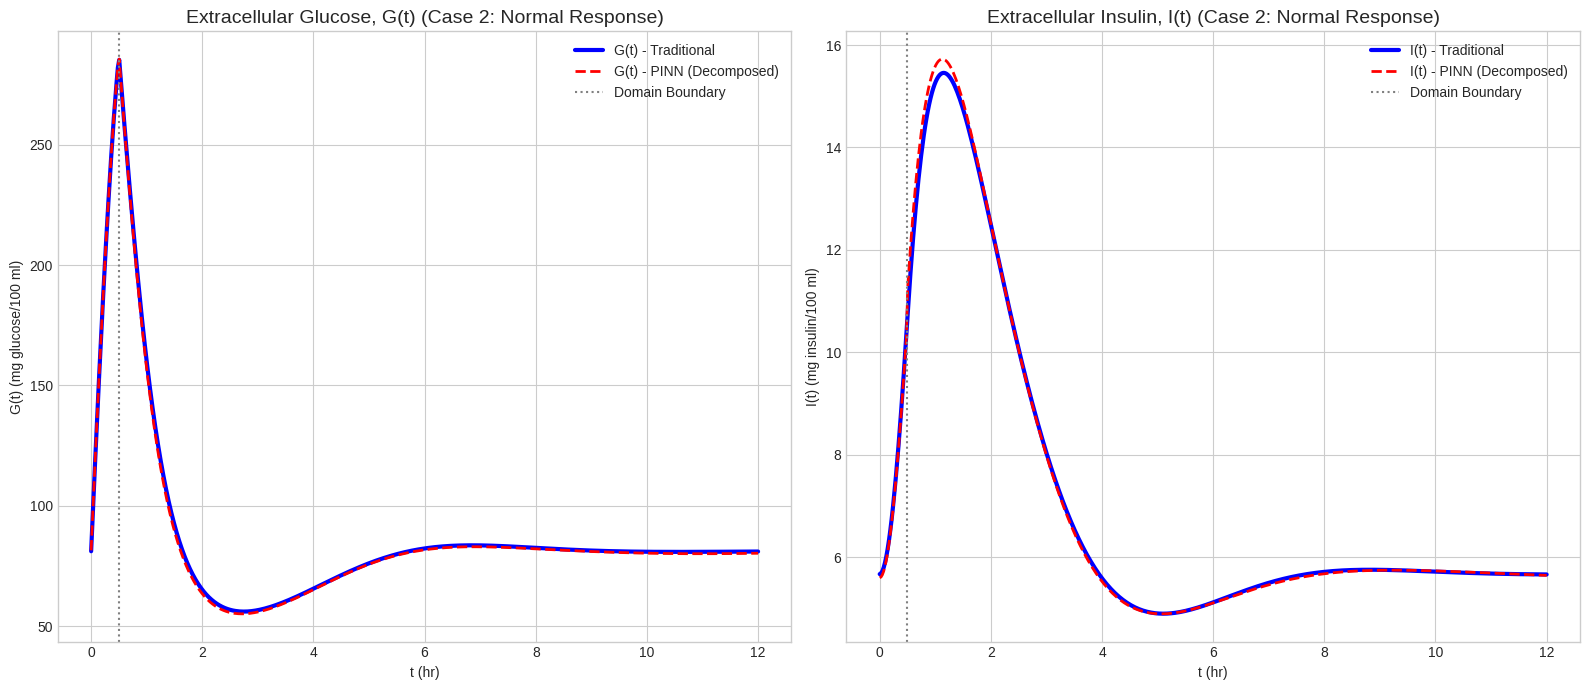


--- Final Values Comparison (at t=12.0 for Case 2) ---
Document G(12): ~81.03 | Traditional G(12): 81.0251 | PINN G(12): 80.3121
Document I(12): ~5.664 | Traditional I(12): 5.6637 | PINN I(12): 5.6454


In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random

# --- 1. Global Setup ---
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Define Exact Parameters for Case 2 (Normal Response) ---
params_ncase2 = {
    'Cg': 150.0, 'Ci': 150.0, 'Q': 8400.0, 'Dd': 24.7,
    'Gg': 13.9, 'Gk': 250.0, 'Mu': 72.0, 'Go': 51.0, 'Aa': 76.0,
    'Bb': 14.3,
    'Gt': 80000.0
}
y0_initial = [81.14, 5.671]
t_span_sim = np.linspace(0, 12, 500)
t_boundary = 0.5

# --- 3. Traditional ODE Solution (Ground Truth for Case 2) ---
def In_func_traditional(t, Gt_val):
    return Gt_val if 0 <= t < t_boundary else 0

def odes_traditional(y, t, params):
    G, I = y; p = params
    In = In_func_traditional(t, p['Gt'])
    dGdt = (p['Q'] + In - p['Gg'] * I * G - p['Dd'] * G) / p['Cg']
    if G >= p['Gk']: dGdt -= (p['Mu'] * (G - p['Gk'])) / p['Cg']
    dIdt = (-p['Aa'] * I) / p['Ci']
    if G >= p['Go']: dIdt += (p['Bb'] * (G - p['Go'])) / p['Ci']
    return [dGdt, dIdt]

print("Calculating traditional ODE solution for Case 2...")
solution_traditional = odeint(odes_traditional, y0_initial, t_span_sim, args=(params_ncase2,))
G_traditional, I_traditional = solution_traditional[:, 0], solution_traditional[:, 1]
print("Traditional solution calculated.")

# --- 4. Advanced PINN Architecture with Time-Domain Decomposition ---
class SinglePINN(nn.Module):
    def __init__(self, t_min, t_max):
        super(SinglePINN, self).__init__()
        self.t_min, self.t_max = t_min, t_max
        self.G_min, self.G_max = 80.0, 290.0
        self.I_min, self.I_max = 4.0, 17.0 # Expanded range is still good practice

        self.net = nn.Sequential(
            nn.Linear(1, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 2)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, t_unscaled):
        t_scaled = 2 * (t_unscaled - self.t_min) / (self.t_max - self.t_min) - 1
        output_scaled = self.net(t_scaled)
        G_pred_unscaled = self.G_min + (self.G_max - self.G_min) * (output_scaled[:, 0] + 1) / 2
        I_pred_unscaled = self.I_min + (self.I_max - self.I_min) * (output_scaled[:, 1] + 1) / 2
        return torch.cat((G_pred_unscaled.unsqueeze(1), I_pred_unscaled.unsqueeze(1)), dim=1)

class DecomposedPINN:
    def __init__(self, params, t_boundary):
        self.params = {k: torch.tensor(v, device=device) for k, v in params.items()}
        self.t_boundary = torch.tensor([[t_boundary]], device=device, requires_grad=True)
        self.pinn1 = SinglePINN(0, t_boundary).to(device)
        self.pinn2 = SinglePINN(t_boundary, 12).to(device)
        self.optimizer = optim.AdamW(
            list(self.pinn1.parameters()) + list(self.pinn2.parameters()),
            lr=1e-3
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', factor=0.7, patience=1000)

    def _compute_residuals(self, pinn, t, with_infusion):
        t.requires_grad_(True)
        y_pred = pinn(t)
        G, I = y_pred[:, 0:1], y_pred[:, 1:2]
        dG_dt = grad(G.sum(), t, create_graph=True)[0]
        dI_dt = grad(I.sum(), t, create_graph=True)[0]
        In_val = self.params['Gt'] if with_infusion else 0.0
        p = self.params
        mu_term = torch.where(G >= p['Gk'], p['Mu'] * (G - p['Gk']), 0.0)
        f_G = p['Cg'] * dG_dt - (p['Q'] + In_val - p['Gg'] * I * G - p['Dd'] * G - mu_term)
        bb_term = torch.where(G >= p['Go'], p['Bb'] * (G - p['Go']), 0.0)
        f_I = p['Ci'] * dI_dt - (-p['Aa'] * I + bb_term)
        return f_G, f_I

    def compute_loss(self, t1_col, t2_col, y0_true):
        f_G1, f_I1 = self._compute_residuals(self.pinn1, t1_col, with_infusion=True)
        loss_ode1 = f_G1.pow(2).mean() + 10.0 * f_I1.pow(2).mean()
        y0_pred = self.pinn1(torch.tensor([[0.0]], device=device))
        loss_ic = ((y0_pred - y0_true) ** 2).sum()
        f_G2, f_I2 = self._compute_residuals(self.pinn2, t2_col, with_infusion=False)
        loss_ode2 = f_G2.pow(2).mean() + 10.0 * f_I2.pow(2).mean()
        y1_boundary = self.pinn1(self.t_boundary)
        y2_boundary = self.pinn2(self.t_boundary)
        loss_cont_val = ((y1_boundary - y2_boundary) ** 2).sum()

        ### CHANGE 1: Dramatically increase the weight of the initial condition loss. ###
        ic_weight = 5000.0  # Was 500.0

        total_loss = (loss_ode1 + loss_ode2 + ic_weight * loss_ic + 100.0 * loss_cont_val)
        loss_ode_total = loss_ode1 + loss_ode2
        return total_loss, (loss_ic, loss_cont_val, loss_ode_total)

    def train(self, epochs, n_col_1, n_col_2, y0_true):
        y0_true_tensor = torch.tensor(y0_true, device=device)
        print("\nStarting Advanced PINN training for Case 2...")
        for epoch in range(1, epochs + 1):
            self.optimizer.zero_grad()
            t1_col = torch.rand(n_col_1, 1, device=device) * self.t_boundary.item()
            t2_col = self.t_boundary.item() + torch.rand(n_col_2, 1, device=device) * (12.0 - self.t_boundary.item())
            loss, (lic, lcv, l_ode) = self.compute_loss(t1_col, t2_col, y0_true_tensor)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step(loss)
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.3e} | "
                      f"ODE: {l_ode.item():.3e} | IC: {lic.item():.3e} | ContVal: {lcv.item():.3e} | "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.2e}")

    ### CHANGE 2: Rewrote the predict function to be more explicit and robust. ###
    def predict(self, t_values):
        t_values = np.array(t_values)
        y_pred = np.zeros((len(t_values), 2))

        # Identify points for each domain
        mask1 = t_values <= self.t_boundary.item()
        mask2 = t_values > self.t_boundary.item()

        t1_points = torch.tensor(t_values[mask1], dtype=torch.float32, device=device).unsqueeze(1)
        t2_points = torch.tensor(t_values[mask2], dtype=torch.float32, device=device).unsqueeze(1)

        with torch.no_grad():
            if t1_points.numel() > 0:
                y_pred1 = self.pinn1(t1_points).cpu().numpy()
                y_pred[mask1] = y_pred1

            if t2_points.numel() > 0:
                y_pred2 = self.pinn2(t2_points).cpu().numpy()
                y_pred[mask2] = y_pred2
        return y_pred

# --- 5. Train and Predict using the Decomposed PINN ---
decomposed_pinn = DecomposedPINN(params_ncase2, t_boundary)
decomposed_pinn.train(epochs=10000, n_col_1=500, n_col_2=2000, y0_true=y0_initial)
y_pinn_pred = decomposed_pinn.predict(t_span_sim)
G_pinn, I_pinn = y_pinn_pred[:, 0], y_pinn_pred[:, 1]

# --- 6. Plotting Results ---
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(t_span_sim, G_traditional, label='G(t) - Traditional', color='blue', linewidth=3)
plt.plot(t_span_sim, G_pinn, label='G(t) - PINN (Decomposed)', color='red', linestyle='--', linewidth=2)
plt.axvline(x=t_boundary, color='gray', linestyle=':', label='Domain Boundary')
plt.title('Extracellular Glucose, G(t) (Case 2: Normal Response)', fontsize=14)
plt.xlabel('t (hr)'), plt.ylabel('G(t) (mg glucose/100 ml)'), plt.grid(True), plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t_span_sim, I_traditional, label='I(t) - Traditional', color='blue', linewidth=3)
plt.plot(t_span_sim, I_pinn, label='I(t) - PINN (Decomposed)', color='red', linestyle='--', linewidth=2)
plt.axvline(x=t_boundary, color='gray', linestyle=':', label='Domain Boundary')
plt.title('Extracellular Insulin, I(t) (Case 2: Normal Response)', fontsize=14)
plt.xlabel('t (hr)'), plt.ylabel('I(t) (mg insulin/100 ml)'), plt.grid(True), plt.legend()
plt.tight_layout(), plt.show()

# --- 7. Verification of Final Values ---
print("\n--- Final Values Comparison (at t=12.0 for Case 2) ---")
print(f"Document G(12): ~81.03 | Traditional G(12): {G_traditional[-1]:.4f} | PINN G(12): {G_pinn[-1]:.4f}")
print(f"Document I(12): ~5.664 | Traditional I(12): {I_traditional[-1]:.4f} | PINN I(12): {I_pinn[-1]:.4f}")

## third case

Using device: cuda
Calculating traditional ODE solution with scipy.integrate.odeint...
Traditional solution calculated.

Starting PINN training...
Epoch 1000/20000:
  ODE Loss G: 3.5069e+07 | ODE Loss I: 3.5891e+01
  IC Loss G: 2.9659e+04 | IC Loss I: 4.2885e+02
  Total ODE Loss (w): 3.7222e+07 | Total IC Loss (w): 3.1803e+07
  Total Loss: 6.9025e+07

Epoch 2000/20000:
  ODE Loss G: 1.3153e+07 | ODE Loss I: 9.2748e+00
  IC Loss G: 1.6353e+03 | IC Loss I: 6.6808e+02
  Total ODE Loss (w): 1.3710e+07 | Total IC Loss (w): 4.9757e+06
  Total Loss: 1.8685e+07

Epoch 3000/20000:
  ODE Loss G: 1.1774e+07 | ODE Loss I: 6.4194e+00
  IC Loss G: 2.0543e+02 | IC Loss I: 4.9254e+02
  Total ODE Loss (w): 1.2159e+07 | Total IC Loss (w): 2.6681e+06
  Total Loss: 1.4827e+07

Epoch 4000/20000:
  ODE Loss G: 1.0686e+07 | ODE Loss I: 2.6017e+01
  IC Loss G: 8.1824e+01 | IC Loss I: 3.4069e+02
  Total ODE Loss (w): 1.2247e+07 | Total IC Loss (w): 1.7853e+06
  Total Loss: 1.4033e+07

Epoch 5000/20000:
  ODE L

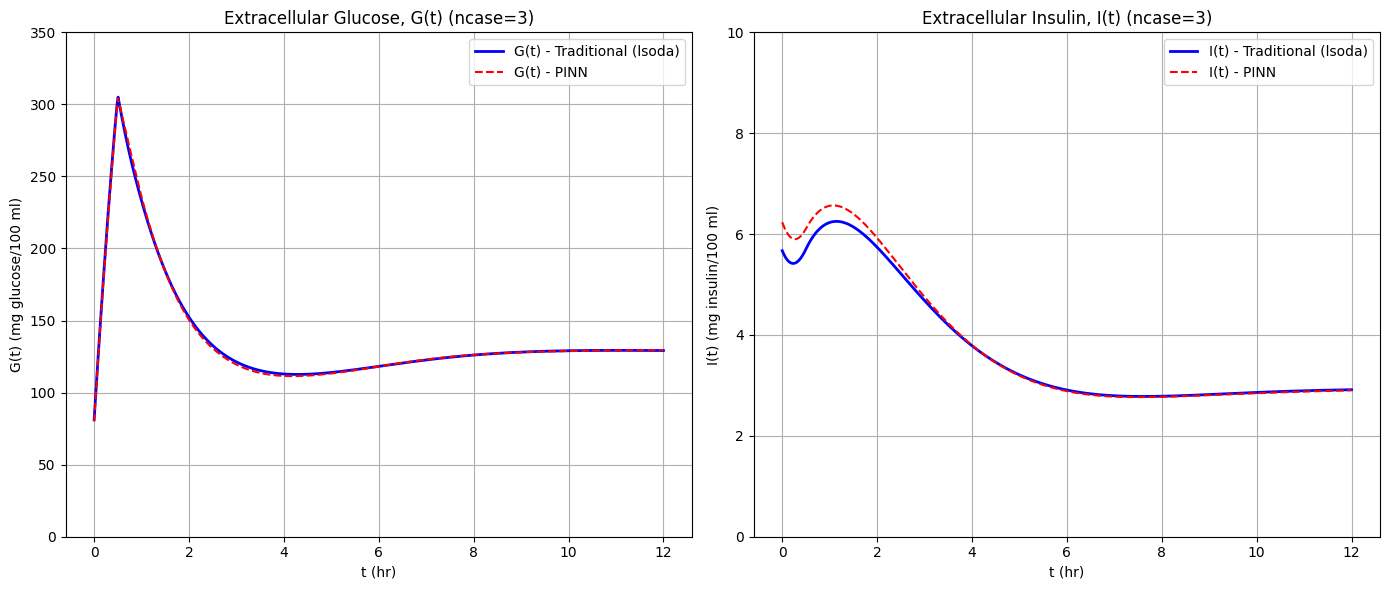


--- Final Values Comparison (at t=12.0) ---
Traditional G(12): 129.2190
Traditional I(12): 2.9145
PINN G(12): 129.5517
PINN I(12): 2.9031


In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random

# --- 1. Global Setup for Reproducibility and Device ---
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Define Parameters for ncase = 3 ---
# Extracted from the document (pages 88, 89, 94)
params_ncase3 = {
    'Ex': 15000,
    'Cg': 150,  # Ex / 100
    'Ci': 150,  # Ex / 100
    'Q': 8400,
    'Dd': 24.7,
    'Gg': 13.9,
    'Gk': 250,
    'Mu': 72,
    'Go': 51,
    'Aa': 76,
    'Bb': 0.2 * 14.3, # Reduced pancreatic sensitivity for ncase=3
    'Gt': 80000 # Glucose infusion rate (used for In)
}

# Initial conditions
y0_initial = [81.14, 5.671] # [G(0), I(0)]

# Time points for simulation
t_span_sim = np.linspace(0, 12, 500) # 500 points for smooth plot

# --- 3. Traditional ODE Solution (using scipy.integrate.odeint) ---

# Glucose infusion function In(t) for traditional solver
def In_func_traditional(t, Gt_val):
    if 0 <= t < 0.5:
        return Gt_val
    else:
        return 0

# ODE system definition for traditional solver
def odes_traditional(y, t, params):
    G, I = y[0], y[1]

    # Unpack parameters
    Cg, Ci, Q, Dd, Gg, Gk, Mu, Go, Aa, Bb, Gt = [params[k] for k in ['Cg','Ci','Q','Dd','Gg','Gk','Mu','Go','Aa','Bb','Gt']]

    In = In_func_traditional(t, Gt)

    # Glucose ODE (Eq. 2.1b & 2.1c)
    dGdt = (Q + In - Gg * I * G - Dd * G)
    if G >= Gk:
        dGdt -= (Mu * (G - Gk))
    dGdt /= Cg

    # Insulin ODE (Eq. 2.2b & 2.2c)
    dIdt = (-Aa * I)
    if G >= Go:
        dIdt += (Bb * (G - Go))
    dIdt /= Ci

    return [dGdt, dIdt]

print("Calculating traditional ODE solution with scipy.integrate.odeint...")
solution_traditional = odeint(odes_traditional, y0_initial, t_span_sim, args=(params_ncase3,))
G_traditional = solution_traditional[:, 0]
I_traditional = solution_traditional[:, 1]
print("Traditional solution calculated.")

# --- 4. Physics-Informed Neural Network (PINN) Implementation ---

# Neural Network Architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.t_min, self.t_max = 0.0, 12.0
        # Estimate reasonable output ranges based on traditional solution's behavior
        self.G_min, self.G_max = 70.0, 310.0
        self.I_min, self.I_max = 2.0, 7.0 # Refined I range based on traditional plot

        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # Store parameters as torch tensors
        for key, value in params_ncase3.items():
            setattr(self, key, torch.tensor(value, dtype=torch.float32).to(device))

    def forward(self, t_unscaled):
        t_scaled = 2 * (t_unscaled - self.t_min) / (self.t_max - self.t_min) - 1
        output_scaled = self.net(t_scaled)
        # Unscale G and I predictions
        G_pred_unscaled = self.G_min + (self.G_max - self.G_min) * (output_scaled[:, 0] + 1) / 2
        I_pred_unscaled = self.I_min + (self.I_max - self.I_min) * (output_scaled[:, 1] + 1) / 2
        return torch.cat((G_pred_unscaled.unsqueeze(1), I_pred_unscaled.unsqueeze(1)), dim=1)

    def In_func_pinn(self, t):
        return torch.where(t < 0.5, self.Gt, torch.tensor(0.0, device=device))

    def compute_ode_residuals(self, t):
        t.requires_grad_(True)
        y_pred = self.forward(t)
        G_pred = y_pred[:, 0:1]
        I_pred = y_pred[:, 1:2]

        dG_dt = grad(G_pred, t, torch.ones_like(G_pred), create_graph=True)[0]
        dI_dt = grad(I_pred, t, torch.ones_like(I_pred), create_graph=True)[0]

        In_val = self.In_func_pinn(t)

        # Renal removal term for Glucose ODE (LHS - RHS)
        # The term is SUBTRACTED from the RHS, so it is ADDED in the residual
        Mu_term = torch.where(G_pred >= self.Gk, self.Mu * (G_pred - self.Gk), torch.tensor(0.0, device=device))

        # Glucose ODE residual
        f_G = self.Cg * dG_dt - (self.Q + In_val - self.Gg * I_pred * G_pred - self.Dd * G_pred) - Mu_term

        # Pancreas release term for Insulin ODE (LHS - RHS)
        # The term is ADDED to the RHS, so it is SUBTRACTED in the residual
        Bb_term = torch.where(G_pred >= self.Go, self.Bb * (G_pred - self.Go), torch.tensor(0.0, device=device))

        # Insulin ODE residual
        f_I = self.Ci * dI_dt - (-self.Aa * I_pred + Bb_term)

        return f_G.pow(2).mean(), f_I.pow(2).mean()

    def compute_initial_condition_loss(self, G0_true, I0_true):
        t0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
        y0_pred = self.forward(t0)
        G0_pred = y0_pred[0, 0]
        I0_pred = y0_pred[0, 1]
        loss_G0 = (G0_pred - G0_true).pow(2)
        loss_I0 = (I0_pred - I0_true).pow(2)
        return loss_G0, loss_I0

pinn_model = PINN().to(device)
optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)

G0_true_tensor = torch.tensor(y0_initial[0], dtype=torch.float32, device=device)
I0_true_tensor = torch.tensor(y0_initial[1], dtype=torch.float32, device=device)

num_collocation_points = 2000
t_collocation = torch.rand((num_collocation_points, 1), device=device) * 12.0

# --- 5. PINN Training Loop ---
epochs = 20000
print("\nStarting PINN training...")
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()

    # Calculate ODE residuals loss
    loss_f_G, loss_f_I = pinn_model.compute_ode_residuals(t_collocation)

    # === Critical Adjustment: Loss Weighting ===
    # Weights are chosen to balance the magnitude of different loss terms.
    # `loss_f_G` is naturally very large, so we scale up other terms to match.
    weight_G_ode = 1.0
    weight_I_ode = 60000.0 # Scale up I_ode loss to be comparable to G_ode
    loss_ode = weight_G_ode * loss_f_G + weight_I_ode * loss_f_I

    # Calculate initial condition loss and apply weights
    # IC losses must be heavily weighted to ensure the solution starts correctly.
    loss_G0, loss_I0 = pinn_model.compute_initial_condition_loss(G0_true_tensor, I0_true_tensor)
    weight_G_ic = 1000.0
    weight_I_ic = 5000.0 # Make sure I(0) is enforced strongly
    loss_ic = weight_G_ic * loss_G0 + weight_I_ic * loss_I0

    # Total loss is the sum of weighted losses
    total_loss = loss_ode + loss_ic

    total_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs}:")
        print(f"  ODE Loss G: {loss_f_G.item():.4e} | ODE Loss I: {loss_f_I.item():.4e}")
        print(f"  IC Loss G: {loss_G0.item():.4e} | IC Loss I: {loss_I0.item():.4e}")
        print(f"  Total ODE Loss (w): {loss_ode.item():.4e} | Total IC Loss (w): {loss_ic.item():.4e}")
        print(f"  Total Loss: {total_loss.item():.4e}\n")

print("PINN training finished.")

# --- 6. Get PINN Predictions for Plotting ---
t_test_pinn = torch.tensor(t_span_sim, dtype=torch.float32, device=device).unsqueeze(1)
with torch.no_grad():
    y_pinn_pred = pinn_model(t_test_pinn)
G_pinn = y_pinn_pred[:, 0].cpu().numpy()
I_pinn = y_pinn_pred[:, 1].cpu().numpy()

# --- 7. Plotting Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t_span_sim, G_traditional, label='G(t) - Traditional (lsoda)', color='blue', linestyle='-', linewidth=2)
plt.plot(t_span_sim, G_pinn, label='G(t) - PINN', color='red', linestyle='--')
plt.title('Extracellular Glucose, G(t) (ncase=3)')
plt.xlabel('t (hr)')
plt.ylabel('G(t) (mg glucose/100 ml)')
plt.grid(True)
plt.legend()
plt.ylim(0, 350)

plt.subplot(1, 2, 2)
plt.plot(t_span_sim, I_traditional, label='I(t) - Traditional (lsoda)', color='blue', linestyle='-', linewidth=2)
plt.plot(t_span_sim, I_pinn, label='I(t) - PINN', color='red', linestyle='--')
plt.title('Extracellular Insulin, I(t) (ncase=3)')
plt.xlabel('t (hr)')
plt.ylabel('I(t) (mg insulin/100 ml)')
plt.grid(True)
plt.legend()
plt.ylim(0, 10)

plt.tight_layout()
plt.show()

# --- 8. Verification of Final Values ---
print("\n--- Final Values Comparison (at t=12.0) ---")
print(f"Traditional G(12): {G_traditional[-1]:.4f}")
print(f"Traditional I(12): {I_traditional[-1]:.4f}")
print(f"PINN G(12): {G_pinn[-1]:.4f}")
print(f"PINN I(12): {I_pinn[-1]:.4f}")

## fourth case

Using device: cpu
Calculating traditional ODE solution...
Traditional solution calculated.

Starting Advanced PINN training...
Epoch 1000/25000 | Loss: 1.442e+06 | IC: 8.500e+02 | ContVal: 5.204e+03 | ContDeriv: 1.962e+01 | LR: 1.00e-03
Epoch 2000/25000 | Loss: 1.140e+06 | IC: 8.866e+02 | ContVal: 4.780e+03 | ContDeriv: 2.481e+01 | LR: 1.00e-03
Epoch 3000/25000 | Loss: 1.110e+06 | IC: 8.374e+02 | ContVal: 4.656e+03 | ContDeriv: 3.491e+01 | LR: 1.00e-03
Epoch 4000/25000 | Loss: 1.034e+06 | IC: 7.746e+02 | ContVal: 4.349e+03 | ContDeriv: 5.437e+01 | LR: 1.00e-03
Epoch 5000/25000 | Loss: 8.196e+05 | IC: 6.431e+02 | ContVal: 2.939e+03 | ContDeriv: 1.041e+02 | LR: 1.00e-03
Epoch 6000/25000 | Loss: 6.718e+05 | IC: 4.733e+02 | ContVal: 1.929e+03 | ContDeriv: 1.700e+02 | LR: 1.00e-03
Epoch 7000/25000 | Loss: 3.651e+05 | IC: 2.691e+02 | ContVal: 8.492e+02 | ContDeriv: 1.861e+02 | LR: 1.00e-03
Epoch 8000/25000 | Loss: 1.315e+05 | IC: 1.156e+02 | ContVal: 1.145e+02 | ContDeriv: 1.561e+02 | LR: 1.

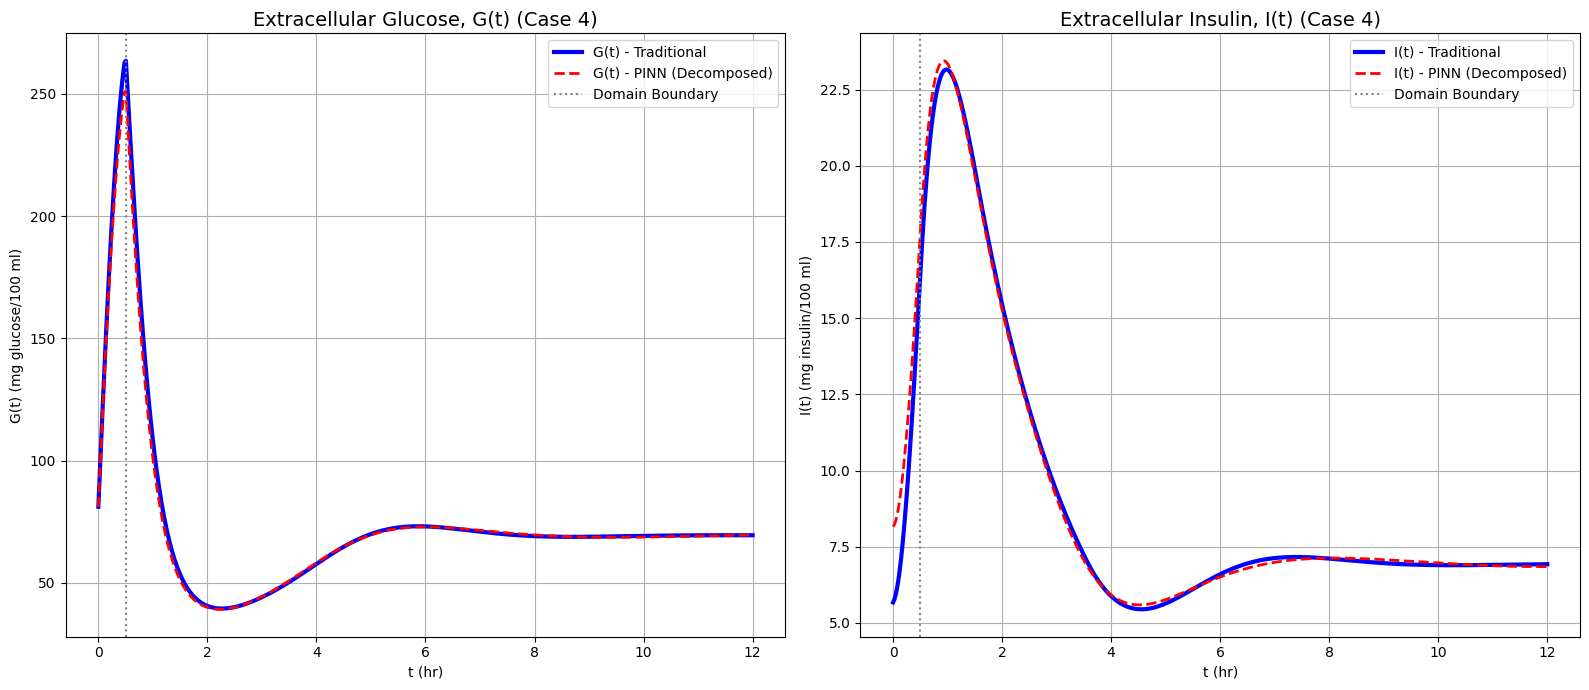


--- Final Values Comparison (at t=12.0 for Case 4) ---
Document G(12): ~69.49 | Traditional G(12): 69.4897 | PINN G(12): 69.6109
Document I(12): ~6.926 | Traditional I(12): 6.9265 | PINN I(12): 6.8477


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random

# --- 1. Global Setup ---
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Define Exact Parameters for Case 4 from Document ---
params_ncase4 = {
    'Cg': 150.0, 'Ci': 150.0, 'Q': 8400.0, 'Dd': 24.7,
    'Gg': 13.9, 'Gk': 250.0, 'Mu': 72.0, 'Go': 51.0, 'Aa': 76.0,
    'Bb': 2.0 * 14.3, 'Gt': 80000.0
}
y0_initial = [81.14, 5.671]
t_span_sim = np.linspace(0, 12, 500)
t_boundary = 0.5 # The point where the ODE changes

# --- 3. Traditional ODE Solution (Ground Truth) ---
def In_func_traditional(t, Gt_val):
    return Gt_val if 0 <= t < t_boundary else 0

def odes_traditional(y, t, params):
    G, I = y; p = params
    In = In_func_traditional(t, p['Gt'])
    dGdt = (p['Q'] + In - p['Gg'] * I * G - p['Dd'] * G) / p['Cg']
    if G >= p['Gk']: dGdt -= (p['Mu'] * (G - p['Gk'])) / p['Cg']
    dIdt = (-p['Aa'] * I) / p['Ci']
    if G >= p['Go']: dIdt += (p['Bb'] * (G - p['Go'])) / p['Ci']
    return [dGdt, dIdt]

print("Calculating traditional ODE solution...")
solution_traditional = odeint(odes_traditional, y0_initial, t_span_sim, args=(params_ncase4,))
G_traditional, I_traditional = solution_traditional[:, 0], solution_traditional[:, 1]
print("Traditional solution calculated.")

# --- 4. Advanced PINN Architecture with Time-Domain Decomposition ---
class SinglePINN(nn.Module):
    """A single PINN module for one time interval."""
    def __init__(self, t_min, t_max):
        super(SinglePINN, self).__init__()
        self.t_min, self.t_max = t_min, t_max
        # Scaling is less critical with domain decomposition, but still good practice
        self.G_min, self.G_max = 40.0, 270.0
        self.I_min, self.I_max = 5.0, 25.0

        self.net = nn.Sequential(
            nn.Linear(1, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 2)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, t_unscaled):
        t_scaled = 2 * (t_unscaled - self.t_min) / (self.t_max - self.t_min) - 1
        output_scaled = self.net(t_scaled)
        G_pred_unscaled = self.G_min + (self.G_max - self.G_min) * (output_scaled[:, 0] + 1) / 2
        I_pred_unscaled = self.I_min + (self.I_max - self.I_min) * (output_scaled[:, 1] + 1) / 2
        return torch.cat((G_pred_unscaled.unsqueeze(1), I_pred_unscaled.unsqueeze(1)), dim=1)

# Main class to manage the two PINNs
class DecomposedPINN:
    def __init__(self, params, t_boundary):
        self.params = {k: torch.tensor(v, device=device) for k, v in params.items()}
        self.t_boundary = torch.tensor([[t_boundary]], device=device, requires_grad=True)

        self.pinn1 = SinglePINN(0, t_boundary).to(device)
        self.pinn2 = SinglePINN(t_boundary, 12).to(device)

        # Use AdamW which often performs better than Adam
        self.optimizer = optim.AdamW(
            list(self.pinn1.parameters()) + list(self.pinn2.parameters()),
            lr=1e-3,
            weight_decay=1e-5
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', factor=0.5, patience=1000)

    def _compute_residuals(self, pinn, t, with_infusion):
        t.requires_grad_(True)
        y_pred = pinn(t)
        G, I = y_pred[:, 0:1], y_pred[:, 1:2]
        dG_dt = grad(G.sum(), t, create_graph=True)[0]
        dI_dt = grad(I.sum(), t, create_graph=True)[0]

        In_val = self.params['Gt'] if with_infusion else 0.0
        p = self.params

        mu_term = torch.where(G >= p['Gk'], p['Mu'] * (G - p['Gk']), 0.0)
        f_G = p['Cg'] * dG_dt - (p['Q'] + In_val - p['Gg'] * I * G - p['Dd'] * G - mu_term)
        bb_term = torch.where(G >= p['Go'], p['Bb'] * (G - p['Go']), 0.0)
        f_I = p['Ci'] * dI_dt - (-p['Aa'] * I + bb_term)
        return f_G, f_I, y_pred

    def compute_loss(self, t1_col, t2_col, y0_true):
        # Loss for PINN 1 (t in [0, 0.5])
        f_G1, f_I1, _ = self._compute_residuals(self.pinn1, t1_col, with_infusion=True)
        loss_ode1 = f_G1.pow(2).mean() + f_I1.pow(2).mean()

        # Initial Condition for PINN 1 at t=0
        y0_pred = self.pinn1(torch.tensor([[0.0]], device=device))
        loss_ic = ((y0_pred - y0_true) ** 2).sum()

        # Loss for PINN 2 (t in [0.5, 12])
        f_G2, f_I2, _ = self._compute_residuals(self.pinn2, t2_col, with_infusion=False)
        loss_ode2 = f_G2.pow(2).mean() + f_I2.pow(2).mean()

        # Continuity Loss at the boundary t=0.5
        # C0 continuity: value must match
        y1_boundary = self.pinn1(self.t_boundary)
        y2_boundary = self.pinn2(self.t_boundary)
        loss_cont_val = ((y1_boundary - y2_boundary) ** 2).sum()

        # C1 continuity: derivative must match
        _, _, y1_deriv_pred = self._compute_residuals(self.pinn1, self.t_boundary, with_infusion=True)
        f_G1_b, f_I1_b, _ = self._compute_residuals(self.pinn1, self.t_boundary, with_infusion=True)
        dGdt1_b = (f_G1_b / self.params['Cg']).detach() # Use the ODE to get the derivative
        dIdt1_b = (f_I1_b / self.params['Ci']).detach()

        f_G2_b, f_I2_b, _ = self._compute_residuals(self.pinn2, self.t_boundary, with_infusion=False)
        dGdt2_b = (f_G2_b / self.params['Cg'])
        dIdt2_b = (f_I2_b / self.params['Ci'])
        loss_cont_deriv = ((dGdt1_b - dGdt2_b)**2 + (dIdt1_b - dIdt2_b)**2).sum()

        # Final weighted loss
        total_loss = (
            1.0 * loss_ode1 +
            1.0 * loss_ode2 +
            500.0 * loss_ic +
            100.0 * loss_cont_val +
            10.0 * loss_cont_deriv
        )
        return total_loss, (loss_ic, loss_cont_val, loss_cont_deriv)

    def train(self, epochs, n_col_1, n_col_2, y0_true):
        y0_true_tensor = torch.tensor(y0_true, device=device)
        print("\nStarting Advanced PINN training...")
        for epoch in range(1, epochs + 1):
            self.optimizer.zero_grad()
            t1_col = torch.rand(n_col_1, 1, device=device) * self.t_boundary.item()
            t2_col = self.t_boundary.item() + torch.rand(n_col_2, 1, device=device) * (12.0 - self.t_boundary.item())

            loss, (lic, lcv, lcd) = self.compute_loss(t1_col, t2_col, y0_true_tensor)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step(loss)

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.3e} | "
                      f"IC: {lic.item():.3e} | ContVal: {lcv.item():.3e} | ContDeriv: {lcd.item():.3e} | "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.2e}")

    def predict(self, t_values):
        t_tensor = torch.tensor(t_values, dtype=torch.float32, device=device).unsqueeze(1)
        with torch.no_grad():
            y_pred1 = self.pinn1(t_tensor[t_values <= self.t_boundary.item()])
            y_pred2 = self.pinn2(t_tensor[t_values > self.t_boundary.item()])
        return np.vstack((y_pred1.cpu().numpy(), y_pred2.cpu().numpy()))


# --- 5. Train and Predict using the Decomposed PINN ---
decomposed_pinn = DecomposedPINN(params_ncase4, t_boundary)
decomposed_pinn.train(epochs=25000, n_col_1=500, n_col_2=2000, y0_true=y0_initial)

y_pinn_pred = decomposed_pinn.predict(t_span_sim)
G_pinn, I_pinn = y_pinn_pred[:, 0], y_pinn_pred[:, 1]

# --- 6. Plotting Results ---
plt.figure(figsize=(16, 7))
# Plot G(t)
plt.subplot(1, 2, 1)
plt.plot(t_span_sim, G_traditional, label='G(t) - Traditional', color='blue', linewidth=3)
plt.plot(t_span_sim, G_pinn, label='G(t) - PINN (Decomposed)', color='red', linestyle='--', linewidth=2)
plt.axvline(x=t_boundary, color='gray', linestyle=':', label='Domain Boundary')
plt.title('Extracellular Glucose, G(t) (Case 4)', fontsize=14)
plt.xlabel('t (hr)'), plt.ylabel('G(t) (mg glucose/100 ml)'), plt.grid(True), plt.legend()
# Plot I(t)
plt.subplot(1, 2, 2)
plt.plot(t_span_sim, I_traditional, label='I(t) - Traditional', color='blue', linewidth=3)
plt.plot(t_span_sim, I_pinn, label='I(t) - PINN (Decomposed)', color='red', linestyle='--', linewidth=2)
plt.axvline(x=t_boundary, color='gray', linestyle=':', label='Domain Boundary')
plt.title('Extracellular Insulin, I(t) (Case 4)', fontsize=14)
plt.xlabel('t (hr)'), plt.ylabel('I(t) (mg insulin/100 ml)'), plt.grid(True), plt.legend()
plt.tight_layout(), plt.show()

# --- 7. Verification of Final Values ---
print("\n--- Final Values Comparison (at t=12.0 for Case 4) ---")
print(f"Document G(12): ~69.49 | Traditional G(12): {G_traditional[-1]:.4f} | PINN G(12): {G_pinn[-1]:.4f}")
print(f"Document I(12): ~6.926 | Traditional I(12): {I_traditional[-1]:.4f} | PINN I(12): {I_pinn[-1]:.4f}")

## comarision between all methods


In [1]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random
import time
from prettytable import PrettyTable

# --- 0. Global Setup & Helper Functions ---
seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

T_SPAN_SIM = np.linspace(0, 12, 500)
Y0_INITIAL = [81.14, 5.671]

def calculate_relative_true_error(true_solution, approximate_solution):
    epsilon = 1e-8
    absolute_error = np.abs(approximate_solution - true_solution) # Swapped order for error calculation
    denominator = np.abs(true_solution) + epsilon
    return (absolute_error / denominator) * 100

# --- 1. Traditional Solver Implementation ---
def In_func_traditional(t, Gt_val): return Gt_val if 0 <= t < 0.5 else 0

def odes_traditional(y, t, params):
    G, I = y[0], y[1]; p = params; In = In_func_traditional(t, p['Gt'])
    dGdt = (p['Q'] + In - p['Gg'] * I * G - p['Dd'] * G) / p['Cg']
    if G >= p['Gk']: dGdt -= (p['Mu'] * (G - p['Gk'])) / p['Cg']
    dIdt = (-p['Aa'] * I) / p['Ci']
    if G >= p['Go']: dIdt += (p['Bb'] * (G - p['Go'])) / p['Ci']
    return [dGdt, dIdt]

def run_traditional_solver(params):
    start_time = time.time()
    solution = odeint(odes_traditional, Y0_INITIAL, T_SPAN_SIM, args=(params,))
    end_time = time.time()
    return solution[:, 0], solution[:, 1], end_time - start_time

# --- 2. PINN Implementations ---
class SimplePINN(nn.Module):
    def __init__(self, params):
        super(SimplePINN, self).__init__()
        self.t_min, self.t_max = 0.0, 12.0
        if params['Gt'] == 0: self.G_min, self.G_max, self.I_min, self.I_max = 80.0, 85.0, 5.0, 6.0
        else: self.G_min, self.G_max, self.I_min, self.I_max = 70.0, 310.0, 2.0, 10.0 # Case 3 scaling
        self.net = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, 2))

        for m in self.net.modules(): # Use .modules() to also get the Sequential itself if needed, or .children() for direct layers
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        self.params = {k: torch.tensor(v, dtype=torch.float32).to(device) for k, v in params.items()}

    def forward(self, t_unscaled):
        t_scaled = 2 * (t_unscaled - self.t_min) / (self.t_max - self.t_min) - 1
        output_scaled = self.net(t_scaled)
        G_pred = self.G_min + (self.G_max - self.G_min) * (output_scaled[:, 0] + 1) / 2
        I_pred = self.I_min + (self.I_max - self.I_min) * (output_scaled[:, 1] + 1) / 2
        return torch.cat((G_pred.unsqueeze(1), I_pred.unsqueeze(1)), dim=1)

    def In_func_pinn(self, t): return torch.where(t < 0.5, self.params['Gt'], torch.tensor(0.0, device=device))

    def compute_ode_residuals(self, t):
        t.requires_grad_(True); y_pred = self.forward(t); G, I = y_pred[:, 0:1], y_pred[:, 1:2]

        # --- FIX START ---
        # Compute gradient of G w.r.t t for each element
        dG_dt = grad(G, t, grad_outputs=torch.ones_like(G), create_graph=True)[0]
        # Compute gradient of I w.r.t t for each element
        dI_dt = grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
        # --- FIX END ---

        p = self.params; In_val = self.In_func_pinn(t)
        mu_term = torch.where(G >= p['Gk'], p['Mu'] * (G - p['Gk']), 0.0)
        f_G = p['Cg'] * dG_dt - (p['Q'] + In_val - p['Gg'] * I * G - p['Dd'] * G - mu_term)
        bb_term = torch.where(G >= p['Go'], p['Bb'] * (G - p['Go']), 0.0)
        f_I = p['Ci'] * dI_dt - (-p['Aa'] * I + bb_term)
        return f_G.pow(2).mean(), f_I.pow(2).mean()

    def compute_initial_condition_loss(self, G0_true, I0_true):
        y0_pred = self.forward(torch.tensor([[0.0]], device=device))
        return ((y0_pred[0, 0] - G0_true)**2), ((y0_pred[0, 1] - I0_true)**2)

class SinglePINN(nn.Module):
    def __init__(self, t_min, t_max, params):
        super(SinglePINN, self).__init__()
        self.t_min, self.t_max = t_min, t_max
        if params['Bb'] > 15: self.G_min, self.G_max, self.I_min, self.I_max = 40.0, 270.0, 5.0, 25.0 # Case 4 scaling
        else: self.G_min, self.G_max, self.I_min, self.I_max = 80.0, 290.0, 5.0, 16.0 # Case 2 scaling
        self.net = nn.Sequential(nn.Linear(1, 40), nn.Tanh(), nn.Linear(40, 40), nn.Tanh(), nn.Linear(40, 40), nn.Tanh(), nn.Linear(40, 2))

        for m in self.net.modules(): # Use .modules()
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, t_unscaled):
        t_scaled = 2 * (t_unscaled - self.t_min) / (self.t_max - self.t_min) - 1
        output_scaled = self.net(t_scaled)
        G_pred = self.G_min + (self.G_max - self.G_min) * (output_scaled[:, 0] + 1) / 2
        I_pred = self.I_min + (self.I_max - self.I_min) * (output_scaled[:, 1] + 1) / 2
        return torch.cat((G_pred.unsqueeze(1), I_pred.unsqueeze(1)), dim=1)

class DecomposedPINN:
    def __init__(self, params, t_boundary):
        self.params_torch = {k: torch.tensor(v, device=device) for k, v in params.items()}
        self.t_boundary = torch.tensor([[t_boundary]], device=device, requires_grad=True)
        self.pinn1 = SinglePINN(0, t_boundary, params).to(device)
        self.pinn2 = SinglePINN(t_boundary, 12, params).to(device)
        # Increased weight decay slightly for AdamW
        self.optimizer = optim.AdamW(list(self.pinn1.parameters()) + list(self.pinn2.parameters()), lr=1e-3, weight_decay=1e-4)
        # Increased patience for ReduceLROnPlateau
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', factor=0.7, patience=2000)

    def _compute_residuals(self, pinn, t, with_infusion):
        t.requires_grad_(True); y_pred = pinn(t); G, I = y_pred[:, 0:1], y_pred[:, 1:2]

        # --- FIX START ---
        # Compute gradient of G w.r.t t for each element
        dG_dt = grad(G, t, grad_outputs=torch.ones_like(G), create_graph=True)[0]
        # Compute gradient of I w.r.t t for each element
        dI_dt = grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
        # --- FIX END ---

        p = self.params_torch; In_val = p['Gt'] if with_infusion else 0.0
        mu_term = torch.where(G >= p['Gk'], p['Mu'] * (G - p['Gk']), 0.0)
        f_G = p['Cg'] * dG_dt - (p['Q'] + In_val - p['Gg'] * I * G - p['Dd'] * G - mu_term)
        bb_term = torch.where(G >= p['Go'], p['Bb'] * (G - p['Go']), 0.0)
        f_I = p['Ci'] * dI_dt - (-p['Aa'] * I + bb_term)
        return f_G, f_I

    def compute_loss(self, t1_col, t2_col, y0_true):
        f_G1, f_I1 = self._compute_residuals(self.pinn1, t1_col, with_infusion=True)
        # Increased weight on I_ode loss
        loss_ode1 = f_G1.pow(2).mean() + 50.0 * f_I1.pow(2).mean() # Adjusted I_ode weight
        y0_pred = self.pinn1(torch.tensor([[0.0]], device=device))
        # Increased initial condition weight significantly
        loss_ic = 5000.0 * ((y0_pred - y0_true)**2).sum() # Adjusted IC weight

        f_G2, f_I2 = self._compute_residuals(self.pinn2, t2_col, with_infusion=False)
        # Increased weight on I_ode loss for second domain
        loss_ode2 = f_G2.pow(2).mean() + 50.0 * f_I2.pow(2).mean() # Adjusted I_ode weight

        y1_b, y2_b = self.pinn1(self.t_boundary), self.pinn2(self.t_boundary)
        # Increased continuity value weight
        loss_cont_val = 500.0 * ((y1_b - y2_b)**2).sum() # Adjusted continuity weight

        total_loss = (loss_ode1 + loss_ode2 + loss_ic + loss_cont_val) # Summing weighted losses

        return total_loss

    def train(self, epochs, n_col_1, n_col_2):
        y0_true_tensor = torch.tensor(Y0_INITIAL, device=device)
        self.pinn1.train(); self.pinn2.train()
        for epoch in range(1, epochs + 1):
            self.optimizer.zero_grad()
            # Add small jitter to collocation points
            t1_col = torch.rand(n_col_1, 1, device=device) * self.t_boundary.item()
            t1_col += (torch.rand_like(t1_col) - 0.5) * (self.t_boundary.item() / n_col_1) # Add jitter
            t1_col = torch.clamp(t1_col, 0, self.t_boundary.item())

            t2_col = self.t_boundary.item() + torch.rand(n_col_2, 1, device=device) * (12.0 - self.t_boundary.item())
            t2_col += (torch.rand_like(t2_col) - 0.5) * ((12.0 - self.t_boundary.item()) / n_col_2) # Add jitter
            t2_col = torch.clamp(t2_col, self.t_boundary.item(), 12.0)


            loss = self.compute_loss(t1_col, t2_col, y0_true_tensor); loss.backward()
            self.optimizer.step(); self.scheduler.step(loss)

    def predict(self, t_values):
        # Sort t_values to ensure correct stacking of predictions from two PINNs
        sorted_indices = np.argsort(t_values)
        t_values_sorted = t_values[sorted_indices]

        t_tensor = torch.tensor(t_values_sorted, dtype=torch.float32, device=device).unsqueeze(1)

        self.pinn1.eval(); self.pinn2.eval()
        y_pred = np.zeros((len(t_values), 2))

        with torch.no_grad():
            mask1 = t_values_sorted <= self.t_boundary.item()
            mask2 = t_values_sorted > self.t_boundary.item()

            if np.any(mask1):
                t1_points = t_tensor[mask1]
                y_pred[mask1] = self.pinn1(t1_points).cpu().numpy()

            if np.any(mask2):
                t2_points = t_tensor[mask2]
                y_pred[mask2] = self.pinn2(t2_points).cpu().numpy()

        # Return predictions in original order
        unsorted_y_pred = np.zeros_like(y_pred)
        unsorted_y_pred[sorted_indices] = y_pred
        return unsorted_y_pred

def run_pinn_simple_timed(params, epochs):
    training_start_time = time.time()
    pinn_model = SimplePINN(params).to(device)
    optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)
    G0_true = torch.tensor(Y0_INITIAL[0], device=device); I0_true = torch.tensor(Y0_INITIAL[1], device=device)
    # Use random collocation points for SimplePINN as well
    t_collocation = torch.rand((1000, 1), device=device) * 12.0
    t_collocation += (torch.rand_like(t_collocation) - 0.5) * (12.0 / 1000) # Add jitter
    t_collocation = torch.clamp(t_collocation, 0, 12.0)

    pinn_model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        loss_f_G, loss_f_I = pinn_model.compute_ode_residuals(t_collocation)
        loss_G0, loss_I0 = pinn_model.compute_initial_condition_loss(G0_true, I0_true)

        # Re-tuned loss weights based on previous attempts and magnitudes observed
        # ODE losses are large, IC losses are smaller but critical.
        weight_G_ode = 1.0
        weight_I_ode = 60000.0 # I_ode is much smaller than G_ode initially
        weight_G_ic = 1000.0
        weight_I_ic = 5000.0 # I_ic is smaller than G_ic

        total_loss = (weight_G_ode * loss_f_G + weight_I_ode * loss_f_I) + (weight_G_ic * loss_G0 + weight_I_ic * loss_I0)

        total_loss.backward(); optimizer.step()
    training_time = time.time() - training_start_time
    inference_start_time = time.time()
    pinn_model.eval()
    with torch.no_grad(): y_pinn_pred = pinn_model(torch.tensor(T_SPAN_SIM, dtype=torch.float32, device=device).unsqueeze(1))
    inference_time = time.time() - inference_start_time
    return y_pinn_pred[:, 0].cpu().numpy(), y_pinn_pred[:, 1].cpu().numpy(), training_time, inference_time

def run_pinn_decomposed_timed(params, epochs):
    training_start_time = time.time()
    decomposed_pinn = DecomposedPINN(params, t_boundary=0.5)
    decomposed_pinn.train(epochs=epochs, n_col_1=500, n_col_2=2000) # Use same n_col points
    training_time = time.time() - training_start_time
    inference_start_time = time.time()
    y_pinn_pred = decomposed_pinn.predict(T_SPAN_SIM)
    inference_time = time.time() - inference_start_time
    return y_pinn_pred[:, 0], y_pinn_pred[:, 1], training_time, inference_time

# --- 3. Main Execution and Reporting Loop ---
if __name__ == "__main__":

    base_params = {
        'Cg': 150.0, 'Ci': 150.0, 'Q': 8400.0, 'Dd': 24.7,
        'Gg': 13.9, 'Gk': 250.0, 'Mu': 72.0, 'Go': 51.0, 'Aa': 76.0,
    }
    case_configs = [
        {'case_num': 1, 'description': 'Normal, No Infusion', 'Bb': 14.3, 'Gt': 0, 'epochs': 5000, 'pinn_type': 'simple'}, # Fewer epochs for this simpler case
        {'case_num': 2, 'description': 'Normal, With Infusion', 'Bb': 14.3, 'Gt': 80000.0, 'epochs': 20000, 'pinn_type': 'decomposed'}, # Increased epochs
        {'case_num': 3, 'description': 'Reduced, With Infusion', 'Bb': 0.2 * 14.3, 'Gt': 80000.0, 'epochs': 25000, 'pinn_type': 'simple'}, # Increased epochs
        {'case_num': 4, 'description': 'Elevated, With Infusion', 'Bb': 2.0 * 14.3, 'Gt': 80000.0, 'epochs': 20000, 'pinn_type': 'decomposed'}, # Increased epochs
    ]
    results_data = []

    for config in case_configs:
        case_num = config['case_num']
        print(f"--- Running Case {case_num}: {config['description']} ---")
        current_params = base_params.copy()
        current_params.update({'Bb': config['Bb'], 'Gt': config['Gt']})
        print("Running traditional solver...")
        G_true, I_true, time_trad = run_traditional_solver(current_params)
        print(f"Traditional solver finished in {time_trad:.4f} seconds.")
        print(f"Running PINN ({config['pinn_type']}) for {config['epochs']} epochs...")
        if config['pinn_type'] == 'simple':
            G_approx, I_approx, time_train, time_infer = run_pinn_simple_timed(current_params, epochs=config['epochs'])
        else:
            G_approx, I_approx, time_train, time_infer = run_pinn_decomposed_timed(current_params, epochs=config['epochs'])
        print(f"PINN finished. Training: {time_train:.2f}s, Inference: {time_infer:.4f}s.\n")
        rte_g = calculate_relative_true_error(G_true, G_approx)
        rte_i = calculate_relative_true_error(I_true, I_approx)
        results_data.append({
            'case': case_num, 'time_trad': time_trad,
            'time_train': time_train, 'time_infer': time_infer,
            'max_rte_g': np.max(rte_g), 'min_rte_g': np.min(rte_g),
            'max_rte_i': np.max(rte_i), 'min_rte_i': np.min(rte_i),
        })

    table = PrettyTable()
    table.title = "PINN vs. Traditional Solver: Time & Error Analysis"
    table.field_names = [
        "Case", "Method", "Execution Time (s)", "Training Time (s)",
        "Max RTE G (%)", "Min RTE G (%)", "Max RTE I (%)", "Min RTE I (%)"
    ]
    table.align["Execution Time (s)"] = "r"; table.align["Training Time (s)"] = "r"
    table.align["Max RTE G (%)"] = "r"; table.align["Min RTE G (%)"] = "r"
    table.align["Max RTE I (%)"] = "r"; table.align["Min RTE I (%)"] = "r"

    for result in results_data:
        if result['case'] > 1:
            table.add_row(["-"*4, "-"*12, "-"*18, "-"*18, "-"*15, "-"*15, "-"*15, "-"*15], divider=True)
        table.add_row([
            result['case'], "Traditional", "-", "N/A",
            "0.0", "0.0", "0.0", "0.0"
        ])
        table.add_row([
            "", "PINN", f"{result['time_infer']:.4f}", f"{result['time_train']:.2f}",
            f"{result['max_rte_g']:.4f}", f"{result['min_rte_g']:.4f}",
            f"{result['max_rte_i']:.4f}", f"{result['min_rte_i']:.4f}"
        ])

    print("\n" + "="*160)
    print(table)
    print("="*160)

Using device: cpu

--- Running Case 1: Normal, No Infusion ---
Running traditional solver...
Traditional solver finished in 0.0034 seconds.
Running PINN (simple) for 5000 epochs...
PINN finished. Training: 84.45s, Inference: 0.0019s.

--- Running Case 2: Normal, With Infusion ---
Running traditional solver...
Traditional solver finished in 0.0016 seconds.
Running PINN (decomposed) for 20000 epochs...
PINN finished. Training: 491.72s, Inference: 0.0227s.

--- Running Case 3: Reduced, With Infusion ---
Running traditional solver...
Traditional solver finished in 0.0017 seconds.
Running PINN (simple) for 25000 epochs...
PINN finished. Training: 356.56s, Inference: 0.0011s.

--- Running Case 4: Elevated, With Infusion ---
Running traditional solver...
Traditional solver finished in 0.0022 seconds.
Running PINN (decomposed) for 20000 epochs...
PINN finished. Training: 494.08s, Inference: 0.0045s.


+--------------------------------------------------------------------------------------------


--- Running Simulations for Case 1: Normal, No Infusion ---
--------------------------------------------------

--- Running Simulations for Case 2: Normal, With Infusion ---
--------------------------------------------------

--- Running Simulations for Case 3: Reduced Pancreatic Sensitivity, With Infusion ---
--------------------------------------------------

--- Running Simulations for Case 4: Elevated Pancreatic Sensitivity, With Infusion ---
--------------------------------------------------

--- Method Comparison Table ---
 Case         Method  Execution Time (s)  ODE Calls  Max Rel Error G  Min Rel Error G  Max Rel Error I  Min Rel Error I
    1          LSODA          2.7449e-03         46              NaN              NaN              NaN              NaN
    1          RKF45          4.8144e-02       2880       7.0083e-07       5.8102e-09       8.1442e-07       2.6141e-09
    1    Trapezoidal          6.8015e-02       7144       7.0037e-07       5.8365e-09       8.1399e-07  

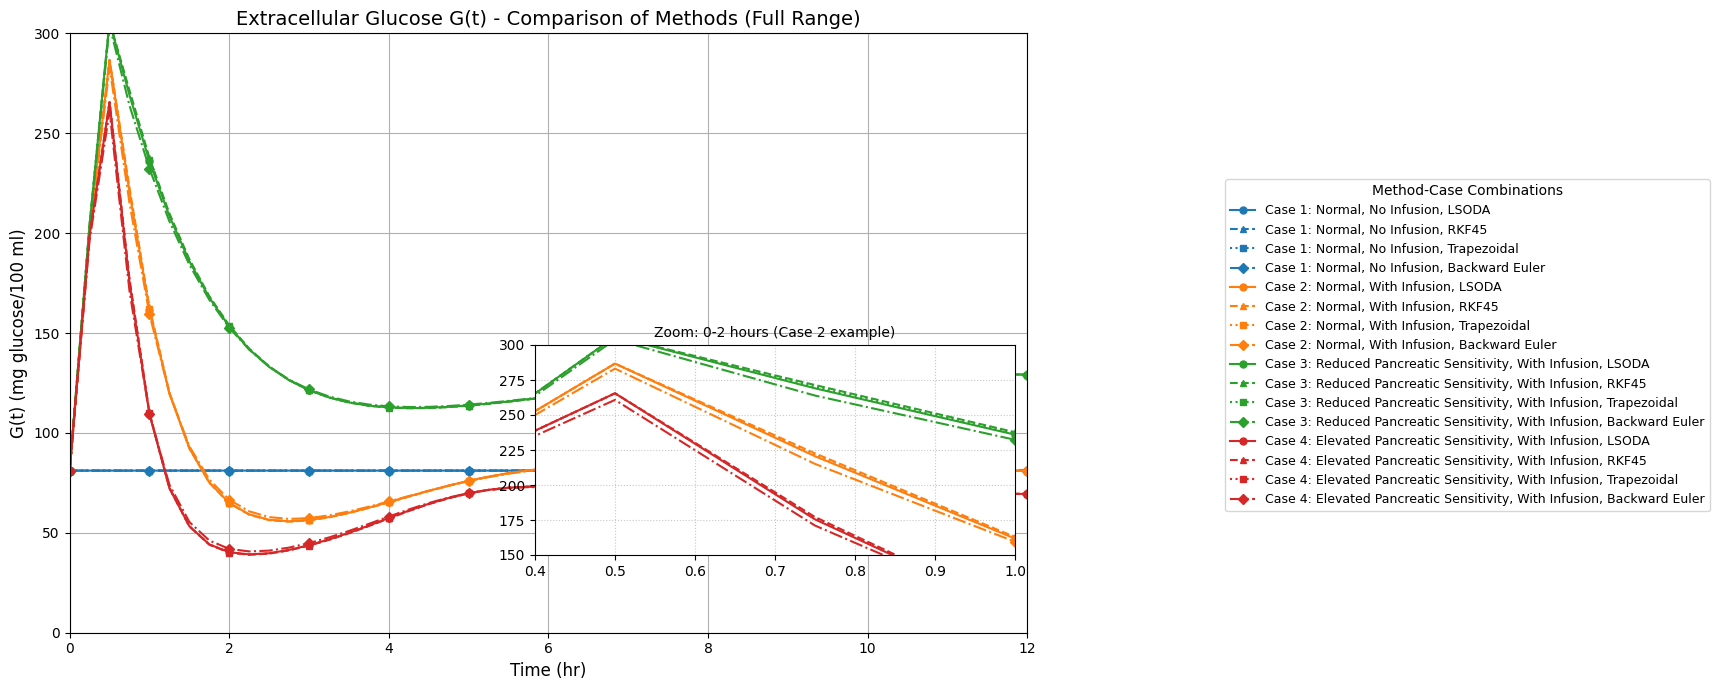

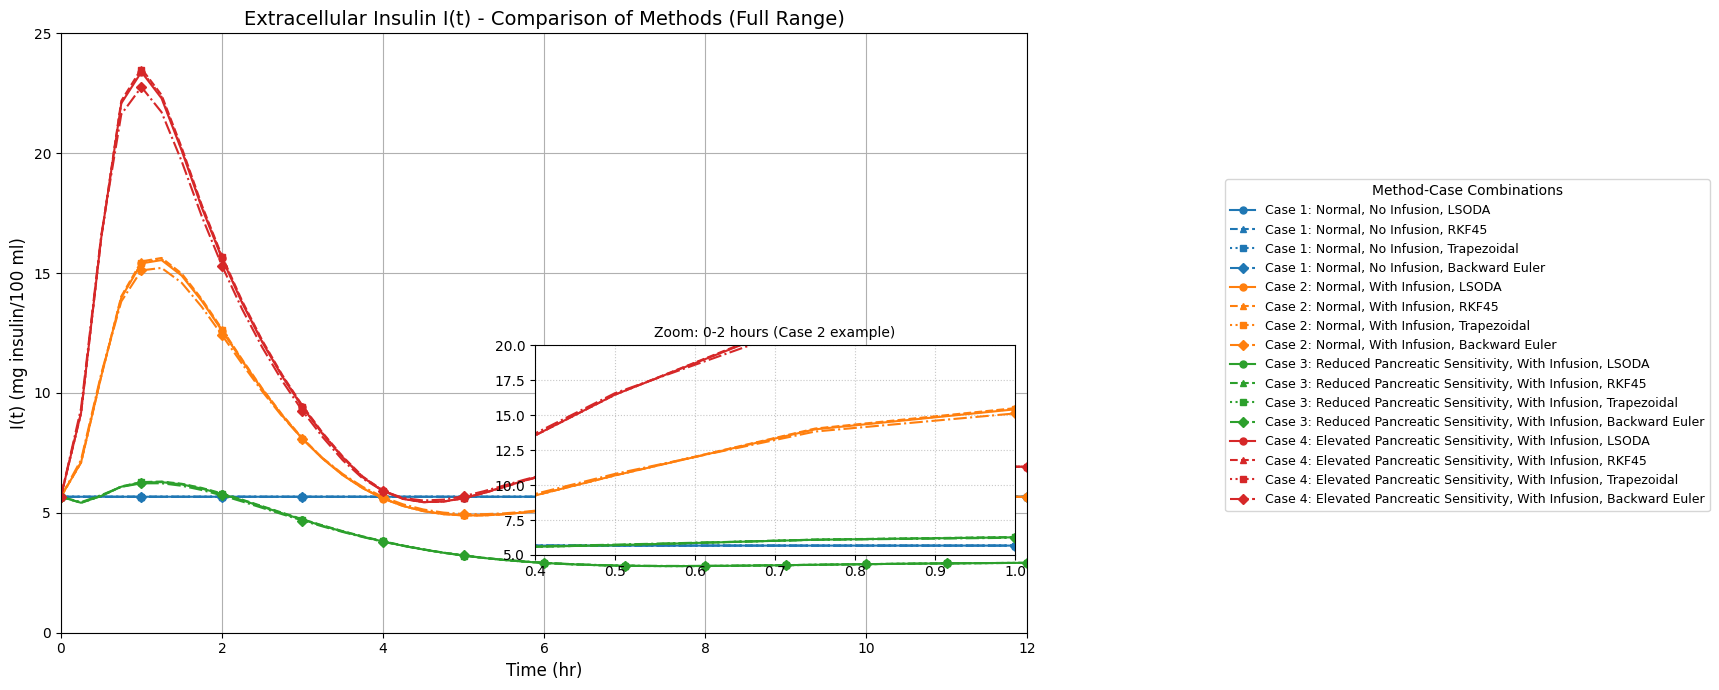

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import time
import pandas as pd # For better table formatting

# Set global matplotlib font properties for better readability
plt.rcParams.update({'font.size': 10, 'lines.markersize': 5})

# --- Global variable to count ODE function calls ---
_ode_call_count = 0

# --------------------------------------------------------------------------
# 1. ODE Routine: glucose_insulin_ode (Common for all methods)
# This function defines the system of differential equations (dG/dt and dI/dt).
# It takes time (t), state variables (y), and parameters (params) as input.
# y[0] is Glucose (G), y[1] is Insulin (I)
# --------------------------------------------------------------------------
def glucose_insulin_ode(t, y, params):
    global _ode_call_count
    _ode_call_count += 1 # Increment call count for every derivative evaluation

    G = y[0]
    I = y[1] # Corrected typo: was I = y[1] = I

    Cg = params['Cg']
    Ci = params['Ci']
    Q = params['Q']
    Dd = params['Dd']
    Gg = params['Gg']
    Gk = params['Gk']
    Mu = params['Mu']
    G0 = params['G0']
    Aa = params['Aa']
    Bb = params['Bb']
    Gt = params['Gt']

    # Glucose infusion function (In)
    if 0 <= t <= 0.51: # Using 0.51 to avoid floating point issues with t=0.5
        In = Gt
    else:
        In = 0

    # Glucose equations (Eqs. 2.1b and 2.1c)
    if G < Gk:
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G)
    else: # G >= Gk
        dGdt = (1 / Cg) * (Q + In - (Gg * I * G) - Dd * G - Mu * (G - Gk))

    # Insulin equations (Eqs. 2.2b and 2.2c)
    if G < G0:
        dIdt = (1 / Ci) * (-Aa * I)
    else: # G >= G0
        dIdt = (1 / Ci) * (-Aa * I + Bb * (G - G0))

    return np.array([dGdt, dIdt])

# --------------------------------------------------------------------------
# 2. Solver Implementations
# Each solver function will return (t_eval, G_sol, I_sol, call_count)
# --------------------------------------------------------------------------

# a. LSODA Solver (using scipy.integrate.solve_ivp)
def solve_lsoda(y0, t_span, t_eval, params, **kwargs): # kwargs for consistency
    global _ode_call_count
    _ode_call_count = 0
    sol = solve_ivp(
        fun=glucose_insulin_ode,
        t_span=t_span,
        y0=y0,
        method='LSODA',
        t_eval=t_eval,
        args=(params,),
        rtol=1e-6,
        atol=1e-6
    )
    return sol.t, sol.y[0], sol.y[1], _ode_call_count

# b. RKF45 Solver (custom implementation based on R code)
def solve_rkf45(y0, t_span, t_eval, params, h_inner):
    global _ode_call_count
    _ode_call_count = 0
    _ee = np.array([0.0, 0.0]) # Error estimate variable, updated but not used for step control in this fixed-step version

    def rkf45_single_step(y_current, t_current, h_step, params_rkf):
        # f_rk_call is a wrapper to call the global ode function but pass rkf params
        def f_rk_call(t_val, y_val):
            return glucose_insulin_ode(t_val, y_val, params_rkf)

        k1 = f_rk_call(t_current, y_current) * h_step
        k2 = f_rk_call(t_current + 0.25 * h_step, y_current + 0.25 * k1) * h_step
        k3 = f_rk_call(t_current + (3/8) * h_step, y_current + (3/32) * k1 + (9/32) * k2) * h_step
        k4 = f_rk_call(t_current + (12/13) * h_step, y_current + (1932/2197) * k1 - (7200/2197) * k2 + (7296/2197) * k3) * h_step
        k5 = f_rk_call(t_current + h_step, y_current + (439/216) * k1 - 8 * k2 + (3680/513) * k3 - (845/4104) * k4) * h_step
        k6 = f_rk_call(t_current + 0.5 * h_step, y_current - (8/27) * k1 + 2 * k2 - (3544/2565) * k3 + (1859/4104) * k4 - (11/40) * k5) * h_step

        y_fifth_order = y_current + (16/135) * k1 + (6656/12825) * k3 + (28561/56430) * k4 - (9/50) * k5 + (2/55) * k6
        y_fourth_order = y_current + (25/216) * k1 + (1408/2565) * k3 + (2197/4104) * k4 - (1/5) * k5
        _ee[:] = y_fifth_order - y_fourth_order
        return y_fifth_order

    G_sol = []
    I_sol = []

    y_current = np.array(y0)
    t_current = t_span[0]

    G_sol.append(y_current[0])
    I_sol.append(y_current[1])

    for i in range(1, len(t_eval)):
        t_target = t_eval[i]
        while t_current < t_target - 1e-12: # Use a small tolerance for floating point comparisons
            step_size_actual = min(h_inner, t_target - t_current)
            if step_size_actual <= 1e-12: break # Avoid tiny or zero step sizes
            y_current = rkf45_single_step(y_current, t_current, step_size_actual, params)
            t_current += step_size_actual
        G_sol.append(y_current[0])
        I_sol.append(y_current[1])

    return np.array(t_eval), np.array(G_sol), np.array(I_sol), _ode_call_count

# c. Trapezoidal Method Solver (Crank-Nicolson)
def solve_trapezoidal(y0, t_span, t_eval, params, h_inner):
    global _ode_call_count
    _ode_call_count = 0

    def trapezoidal_function(y_next_guess, y_current_step, t_current_step, t_next_step, h_step, params_trap):
        f_current = glucose_insulin_ode(t_current_step, y_current_step, params_trap)
        f_next = glucose_insulin_ode(t_next_step, y_next_guess, params_trap)
        return y_next_guess - y_current_step - (h_step / 2) * (f_current + f_next)

    G_sol = []
    I_sol = []

    y_current = np.array(y0)
    t_current = t_span[0]

    G_sol.append(y_current[0])
    I_sol.append(y_current[1])

    for i in range(1, len(t_eval)):
        t_target = t_eval[i]
        while t_current < t_target - 1e-12:
            step_size_actual = min(h_inner, t_target - t_current)
            if step_size_actual <= 1e-12: break

            y_next_guess = y_current
            y_next_solved, info, ier, msg = fsolve(
                trapezoidal_function,
                y_next_guess,
                args=(y_current, t_current, t_current + step_size_actual, step_size_actual, params),
                full_output=True, xtol=1e-8, maxfev=1000
            )
            if ier != 1: pass # Suppress convergence warnings
            y_current = y_next_solved
            t_current += step_size_actual
        G_sol.append(y_current[0])
        I_sol.append(y_current[1])

    return np.array(t_eval), np.array(G_sol), np.array(I_sol), _ode_call_count

# d. Backward Euler Solver
def solve_backward_euler(y0, t_span, t_eval, params, h_inner):
    global _ode_call_count
    _ode_call_count = 0

    def implicit_euler_function(y_next_guess, y_current_step, t_next_step, h_step, params_be):
        f_next = glucose_insulin_ode(t_next_step, y_next_guess, params_be)
        return y_next_guess - y_current_step - h_step * f_next

    G_sol = []
    I_sol = []

    y_current = np.array(y0)
    t_current = t_span[0]

    G_sol.append(y_current[0])
    I_sol.append(y_current[1])

    for i in range(1, len(t_eval)):
        t_target = t_eval[i]
        while t_current < t_target - 1e-12:
            step_size_actual = min(h_inner, t_target - t_current)
            if step_size_actual <= 1e-12: break

            y_next_guess = y_current
            y_next_solved, info, ier, msg = fsolve(
                implicit_euler_function,
                y_next_guess,
                args=(y_current, t_current + step_size_actual, step_size_actual, params),
                full_output=True, xtol=1e-8, maxfev=1000
            )
            if ier != 1: pass # Suppress convergence warnings
            y_current = y_next_solved
            t_current += step_size_actual
        G_sol.append(y_current[0])
        I_sol.append(y_current[1])

    return np.array(t_eval), np.array(G_sol), np.array(I_sol), _ode_call_count


# --------------------------------------------------------------------------
# 3. Main Simulation and Comparison Logic
# --------------------------------------------------------------------------

# General Simulation Settings
nout = 49
t_span = (0, 12)
times_output = np.linspace(t_span[0], t_span[1], nout)
yini = [81.14, 5.671]

# Fixed model parameters
fixed_params = {
    'Ex': 15000, 'Cg': 150, 'Ci': 150,
    'Q': 8400, 'Dd': 24.7, 'Gg': 13.9,
    'Gk': 250, 'Mu': 72, 'G0': 51, 'Aa': 76
}

# Simulation Cases
cases_setup = [
    {'Bb': 14.3, 'Gt': 0, 'label': 'Case 1: Normal, No Infusion'},
    {'Bb': 14.3, 'Gt': 80000, 'label': 'Case 2: Normal, With Infusion'},
    {'Bb': 0.2 * 14.3, 'Gt': 80000, 'label': 'Case 3: Reduced Pancreatic Sensitivity, With Infusion'},
    {'Bb': 2.0 * 14.3, 'Gt': 80000, 'label': 'Case 4: Elevated Pancreatic Sensitivity, With Infusion'}
]

# Methods to compare (and their inner step size for fixed-step methods)
methods_config = {
    "LSODA": {"solver_func": solve_lsoda, "h_inner": None},
    "RKF45": {"solver_func": solve_rkf45, "h_inner": 0.025},
    "Trapezoidal": {"solver_func": solve_trapezoidal, "h_inner": 0.025},
    "Backward Euler": {"solver_func": solve_backward_euler, "h_inner": 0.025}
}

# Data structures to store all results and metrics
all_results = {}
comparison_metrics = []

# Run simulations for all cases and methods
for ncase_idx, case_config in enumerate(cases_setup):
    ncase = ncase_idx + 1
    print(f"\n--- Running Simulations for {case_config['label']} ---")

    current_params = fixed_params.copy()
    current_params.update(case_config)

    all_results[ncase] = {}

    lsoda_t, lsoda_G, lsoda_I = (None, None, None) # Reference for error calculation

    for method_name, config in methods_config.items():
        solver_func = config["solver_func"]
        h_inner = config["h_inner"]

        start_time = time.time()

        t_sol, G_sol, I_sol, ode_calls = solver_func(yini, t_span, times_output, current_params, h_inner=h_inner)

        end_time = time.time()
        exec_time = end_time - start_time

        all_results[ncase][method_name] = {
            't': t_sol, 'G': G_sol, 'I': I_sol
        }

        if method_name == "LSODA":
            lsoda_t, lsoda_G, lsoda_I = t_sol, G_sol, I_sol
            comparison_metrics.append({
                'Case': ncase, 'Method': method_name,
                'Execution Time (s)': exec_time,
                'ODE Calls': ode_calls,
                'Max Rel Error G': np.nan, 'Min Rel Error G': np.nan,
                'Max Rel Error I': np.nan, 'Min Rel Error I': np.nan
            })
        else:
            eps = 1e-12

            # Calculate Relative Error against LSODA (reference)
            # Filter out points where LSODA reference is zero or near zero to avoid division by zero/large errors
            # Also exclude initial point (t=0) as it's the exact IC and relative error is often ill-defined.
            # Using absolute values for filtering to ensure correct behavior near zero.
            valid_indices = (np.abs(lsoda_G) > eps) & (np.abs(lsoda_I) > eps) & (times_output > 0)

            rel_err_G = np.abs((G_sol[valid_indices] - lsoda_G[valid_indices]) / lsoda_G[valid_indices])
            rel_err_I = np.abs((I_sol[valid_indices] - lsoda_I[valid_indices]) / lsoda_I[valid_indices])

            # Ensure no NaNs or Infs from calculation
            rel_err_G = rel_err_G[np.isfinite(rel_err_G)]
            rel_err_I = rel_err_I[np.isfinite(rel_err_I)]

            max_rel_G = np.max(rel_err_G) if rel_err_G.size > 0 else np.nan
            min_rel_G = np.min(rel_err_G) if rel_err_G.size > 0 else np.nan
            max_rel_I = np.max(rel_err_I) if rel_err_I.size > 0 else np.nan
            min_rel_I = np.min(rel_err_I) if rel_err_I.size > 0 else np.nan

            comparison_metrics.append({
                'Case': ncase, 'Method': method_name,
                'Execution Time (s)': exec_time,
                'ODE Calls': ode_calls,
                'Max Rel Error G': max_rel_G, 'Min Rel Error G': min_rel_G,
                'Max Rel Error I': max_rel_I, 'Min Rel Error I': min_rel_I
            })
    print("-" * 50)

# Convert comparison metrics to DataFrame for pretty printing
comparison_df = pd.DataFrame(comparison_metrics)

# Set display options for better printing of floats and columns
pd.set_option('display.float_format', '{:.4e}'.format)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("\n--- Method Comparison Table ---")
print(comparison_df.to_string(index=False))
print("\n*Note: Relative errors are calculated against LSODA solution. N/A for LSODA as it is the reference.")
print("Errors are filtered to exclude the initial time point and instances where the LSODA reference is zero/near zero.")


# --------------------------------------------------------------------------
# 4. Combined Plotting with Zoomed Insets for Clearer Differences
# --------------------------------------------------------------------------

# Define consistent styles for each method
# Each method gets a unique linestyle and marker for easy identification across cases
method_plotting_styles = {
    "LSODA": {'linestyle': '-', 'marker': 'o',  'markevery': 4, 'linewidth': 1.5},
    "RKF45": {'linestyle': '--', 'marker': '^', 'markevery': 4, 'linewidth': 1.5},
    "Trapezoidal": {'linestyle': ':', 'marker': 's', 'markevery': 4, 'linewidth': 1.5},
    "Backward Euler": {'linestyle': '-.', 'marker': 'D',  'markevery': 4, 'linewidth': 1.5}
}

# Define distinct colors for each case
case_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red'
}

# --- Plot for Glucose (G) ---
fig_G, ax_G = plt.subplots(figsize=(12, 7))

# Plot all 16 lines on the main axis
for ncase in all_results.keys():
    case_label = cases_setup[ncase-1]['label']
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        # Combine case and method into a single label for the legend
        label_text = f"{case_label}, {method_name}"
        ax_G.plot(data['t'], data['G'],
                  color=case_colors[ncase], **style, label=label_text)

ax_G.set_xlabel("Time (hr)", fontsize=12)
ax_G.set_ylabel("G(t) (mg glucose/100 ml)", fontsize=12)
ax_G.set_xlim(0, 12)
ax_G.set_ylim(0, 300)
ax_G.set_title("Extracellular Glucose G(t) - Comparison of Methods (Full Range)", fontsize=14)
ax_G.grid(True)

# Create a custom legend for all lines, placed outside the plot for readability
handles, labels = ax_G.get_legend_handles_labels()
fig_G.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, fontsize=9, title="Method-Case Combinations")
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make space for the legend

# --- Add an Inset Subplot for a zoomed-in view of G(t) ---
# This helps to clearly see point-to-point differences and small variations
ax_G_inset = fig_G.add_axes([0.45, 0.2, 0.4, 0.3]) # [left, bottom, width, height] in figure coordinates
for ncase in all_results.keys():
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        ax_G_inset.plot(data['t'], data['G'], color=case_colors[ncase], **style)

ax_G_inset.set_title('Zoom: 0-2 hours (Case 2 example)', fontsize=10) # Focused title
ax_G_inset.set_xlim(0.4, 1.0) # More tightly zoomed range for a specific transient
ax_G_inset.set_ylim(150, 300) # Adjust Y-limit for better visibility in zoomed area
ax_G_inset.grid(True, linestyle=':', alpha=0.7)
plt.show()

# --- Plot for Insulin (I) ---
fig_I, ax_I = plt.subplots(figsize=(12, 7))

# Plot all 16 lines on the main axis
for ncase in all_results.keys():
    case_label = cases_setup[ncase-1]['label']
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        label_text = f"{case_label}, {method_name}"
        ax_I.plot(data['t'], data['I'],
                  color=case_colors[ncase], **style, label=label_text)

ax_I.set_xlabel("Time (hr)", fontsize=12)
ax_I.set_ylabel("I(t) (mg insulin/100 ml)", fontsize=12)
ax_I.set_xlim(0, 12)
ax_I.set_ylim(0, 25)
ax_I.set_title("Extracellular Insulin I(t) - Comparison of Methods (Full Range)", fontsize=14)
ax_I.grid(True)

# Create a custom legend for all lines, placed outside the plot for readability
handles, labels = ax_I.get_legend_handles_labels()
fig_I.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, fontsize=9, title="Method-Case Combinations")
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout

# --- Add an Inset Subplot for a zoomed-in view of I(t) ---
ax_I_inset = fig_I.add_axes([0.45, 0.2, 0.4, 0.3]) # [left, bottom, width, height] in figure coordinates
for ncase in all_results.keys():
    for method_name, style in method_plotting_styles.items():
        data = all_results[ncase][method_name]
        ax_I_inset.plot(data['t'], data['I'], color=case_colors[ncase], **style)

ax_I_inset.set_title('Zoom: 0-2 hours (Case 2 example)', fontsize=10) # Focused title
ax_I_inset.set_xlim(0.4, 1.0) # More tightly zoomed range
ax_I_inset.set_ylim(5, 20) # Adjust Y-limit for better visibility
ax_I_inset.grid(True, linestyle=':', alpha=0.7)
plt.show()